In [61]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [62]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html

# Set the model to evaluation mode
model.eval()

print("Model Loaded")

Model Loaded


In [104]:
def display_bounding_boxes(input_image: torch.Tensor, 
                           model_outputs: dict, 
                           thresh=0.8, 
                           show_labels:bool = False, 
                           save_path=None):
    """
    Display bounding boxes on the image, annotate each with its label and score, and save the annotated image.

    Parameters:
    - input_image: torch.Tensor, the input image tensor.
    - model_outputs: dict, the output from the detection model.
    - thresh: float, the score threshold for displaying bounding boxes.
    - show_labels: bool, whether to display labels on the image.
    - save_path: str, the path to save the annotated image.
    """

    # Assuming 'labels' and 'scores' are keys in the model_outputs dict
    boxes = model_outputs[0]['boxes']
    scores = model_outputs[0]['scores']
    labels = model_outputs[0]['labels']  # Assuming there's a 'labels' key

    # Convert to numpy arrays and filter by score threshold
    cleaned_boxes = []
    cleaned_scores = []
    cleaned_labels = []
    for box, score, label in zip(boxes, scores, labels):
        if score >= thresh:
            box = box.detach().numpy().astype(int)
            cleaned_boxes.append(box)
            cleaned_scores.append(score.detach().numpy())
            cleaned_labels.append(str(label))

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0).numpy())  # Adjusted for tensor format (C, H, W)

    # Create a Rectangle patch and label for each cleaned box and add to the plot
    for box, score, label in zip(cleaned_boxes, cleaned_scores, cleaned_labels):
        # Draw rectangle
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        if show_labels:
            # Annotate label and score
            ax.text(box[0], box[1]-10, f'{label}: {score*100:.0f}%', color='#8B0000', fontsize=8, fontweight='bold')

    # Hide axes
    ax.axis('off')
    # Save the figure
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    

In [64]:
# Pass test_image.jpg thrpugh the model
image_path = '../data/test_image_2.jpg'
image = Image.open(image_path)
print(type(image))

# Dont need to normalize the input iamges, the pytorch model does it internally
tensor_transform = transforms.ToTensor()
image = image.resize((800, 400))
# Apply the transformation to your image
normalized_image = tensor_transform(image).unsqueeze(0)

outputs = model(normalized_image)
print(outputs)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


[{'boxes': tensor([[3.6143e+02, 9.0196e+01, 4.0315e+02, 1.4412e+02],
        [3.0143e+02, 2.5488e+02, 3.7340e+02, 3.5119e+02],
        [3.5827e+02, 1.3188e+01, 4.0029e+02, 9.3604e+01],
        [3.8145e+02, 1.0698e+00, 4.1756e+02, 7.9103e+01],
        [5.9245e+01, 1.2424e+02, 1.0501e+02, 1.7429e+02],
        [2.8602e+02, 3.3758e+02, 3.4772e+02, 3.7983e+02],
        [2.0915e+02, 1.4119e+02, 2.8385e+02, 2.5521e+02],
        [6.3962e+00, 0.0000e+00, 3.4175e+02, 3.7395e+02],
        [2.1432e+00, 2.4057e+02, 2.6093e+02, 3.9688e+02],
        [1.8728e+01, 1.5205e+02, 9.3091e+01, 2.5474e+02],
        [1.9099e+01, 1.0107e+02, 1.3561e+02, 2.4844e+02],
        [5.6918e+01, 1.0747e+02, 1.2789e+02, 1.7865e+02],
        [3.6445e+02, 3.1227e+01, 3.9451e+02, 7.4538e+01],
        [2.2468e+02, 5.0853e-01, 2.6839e+02, 3.7974e+01],
        [2.1279e+02, 1.3818e+02, 2.6802e+02, 2.0037e+02],
        [1.7806e+02, 6.3885e-01, 2.1082e+02, 2.9277e+01],
        [7.6175e+00, 4.1442e+00, 2.3679e+02, 3.1210e+02],
   

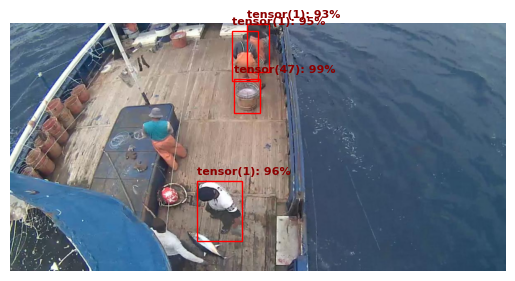

In [105]:
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=0.9, show_labels=True)

In [66]:
def calc_iou(box1: list, box2: list):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Args:
        box1: list of floats (x_min, y_min, x_max, y_max)
        box2: list of floats (x_min, y_min, x_max, y_max)

    Returns:
        float: intersection over union (IoU) between box1 and box2
    """
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # compute the IoU
    iou = intersection_area / union_area

    return iou
    


In [71]:
# # Show all model layers
# for name, param in model.named_parameters():
#     print(name, param.size())

In [73]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")

# # Freeze all model parameters
# for param in model.parameters():
#     param.requires_grad = False

# Replace the box predictor (classifier head)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 26  # Update this if you have a different number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load your saved model weights for CPU
path_to_saved_weights = '../data/best_model.pth'  # Update this path
model.load_state_dict(torch.load(path_to_saved_weights, map_location=torch.device('cpu')))

# Your model is now ready to be used with the updated weights and box predictor
model.eval()

print("Model Loaded")

Model Loaded


In [82]:
def filter_outputs_by_threshold(outputs, threshold):
    filtered_outputs = []
    for output in outputs:
        # Apply threshold to 'scores' and filter 'boxes' and 'labels' accordingly
        keep = output['scores'] > threshold
        filtered_output = {key: value[keep] for key, value in output.items()}
        filtered_outputs.append(filtered_output)
    return filtered_outputs[0]


def convert_labels_to_string_old_model(outputs: dict) -> dict:
    converted_outputs = {"boxes": [], "labels": [], "scores": []}
    # Convert numerical labels to string labels
    for i in range(len(outputs["scores"])):
        if outputs["labels"][i] == 1:
            converted_outputs["labels"].append("Human")
            converted_outputs["boxes"].append(outputs["boxes"][i])
            converted_outputs["scores"].append(outputs["scores"][i])
    return converted_outputs


def convert_labels_to_string_new_model(outputs: dict) -> dict:
    id_to_class = {0: "Human", 1: "Swordfish", 2: "Albacore", 3: "Yellowfin tuna", 4: "No fish", 5: "Mahi mahi", 6: "Skipjack tuna", 7: "Unknown", 8: "Wahoo", 9: "Bigeye tuna", 10: "Striped marlin", 11: "Opah", 12: "Blue marlin", 13: "Escolar", 14: "Shark", 15: "Tuna", 16: "Water", 17: "Oilfish", 18: "Pelagic stingray", 19: "Marlin", 20: "Great barracuda", 21: "Shortbill spearfish", 22: "Indo Pacific sailfish", 23: "Lancetfish", 24: "Long snouted lancetfish", 25: "Black marlin"}
    converted_outputs = {"boxes": [], "labels": [], "scores": []}
    # Convert numerical labels to string labels
    for i in range(len(outputs["scores"])):
        converted_outputs["labels"].append(id_to_class[outputs["labels"][i].item()])
        converted_outputs["boxes"].append(outputs["boxes"][i])
        converted_outputs["scores"].append(outputs["scores"][i])
    return converted_outputs

def combine_outputs(outputs_old: dict, outputs_new: dict):
    # Convert numerical labels to string labels
    outputs_old = convert_labels_to_string_old_model(outputs_old)
    outputs_new = convert_labels_to_string_new_model(outputs_new)
    
    combined_outputs = {}
    combined_outputs["boxes"] = outputs_old["boxes"] + outputs_new["boxes"]
    combined_outputs["labels"] = outputs_old["labels"] + outputs_new["labels"]
    combined_outputs["scores"] = outputs_old["scores"] + outputs_new["scores"]

    return [combined_outputs]




{'boxes': tensor([[280.2973, 334.0477, 360.8921, 388.7295]], grad_fn=<IndexBackward0>), 'labels': tensor([2]), 'scores': tensor([0.8586], grad_fn=<IndexBackward0>)}
[{'boxes': [tensor([301.4314, 254.8831, 373.3976, 351.1941], grad_fn=<SelectBackward0>), tensor([358.2712,  13.1885, 400.2933,  93.6038], grad_fn=<SelectBackward0>), tensor([381.4526,   1.0698, 417.5576,  79.1034], grad_fn=<SelectBackward0>), tensor([ 59.2451, 124.2421, 105.0111, 174.2860], grad_fn=<SelectBackward0>), tensor([280.2973, 334.0477, 360.8921, 388.7295], grad_fn=<SelectBackward0>)], 'labels': ['Human', 'Human', 'Human', 'Human', 'Albacore'], 'scores': [tensor(0.9641, grad_fn=<SelectBackward0>), tensor(0.9464, grad_fn=<SelectBackward0>), tensor(0.9286, grad_fn=<SelectBackward0>), tensor(0.8722, grad_fn=<SelectBackward0>), tensor(0.8586, grad_fn=<SelectBackward0>)]}]


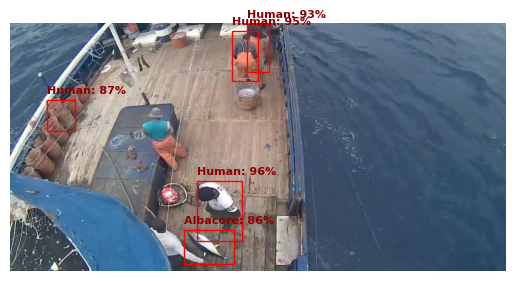

In [106]:

#resize the image to 400x800 pixels
image = Image.open('../data/test_image_2.jpg')
image = image.resize((800, 400))
normalized_image = tensor_transform(image).unsqueeze(0)
#make new list outputs and new_outputs together
new_outputs = filter_outputs_by_threshold(model(normalized_image),0.4)
combined_outputs = combine_outputs(filter_outputs_by_threshold(outputs,0.8), new_outputs)
print(new_outputs)
display_bounding_boxes(tensor_transform(image).unsqueeze(0),combined_outputs, thresh=0.8, show_labels=True, save_path='../data/test_image_2_output.jpg')
print(combined_outputs)